In [1]:
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl

from src.constant import LABELS
from src.preprocess import load_eeg, process_label, calc_weight
from src.visualization import format_time, plot_eeg

plt.style.use("tableau-colorblind10")

In [4]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata = metadata.group_by("eeg_id").agg(
    *[
        pl.col(f"{label}_prob_per_eeg").first().alias(f"{label}_prob")
        for label in LABELS
    ],
    pl.col("weight_per_eeg").first().alias("weight"),
)
metadata.head()

eeg_id,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
i64,f64,f64,f64,f64,f64,f64,f64
1454127370,0.0,0.0,0.0,0.0,0.0,1.0,0.035714
1277613710,0.066667,0.2,0.0,0.333333,0.0,0.4,0.535714
1516436739,0.0,0.0,0.0,0.0,0.0,1.0,0.071429
3936987921,0.0,0.0,0.0,0.0,0.0,1.0,0.107143
3743030929,1.0,0.0,0.0,0.0,0.0,0.0,0.107143


seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
f64,f64,f64,f64,f64,f64,f64
0.205773,0.123783,0.093906,0.062076,0.126522,0.387941,0.091358


seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
f64,f64,f64,f64,f64,f64,f64
0.041959,0.18154,0.12532,0.072379,0.090424,0.488378,0.513


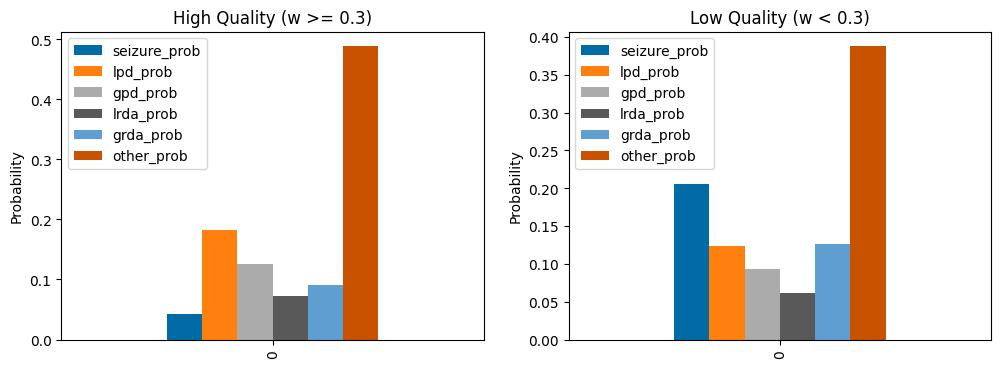

In [30]:
high_quality = metadata.filter(pl.col("weight").ge(0.3))
low_quality = metadata.filter(pl.col("weight").lt(0.3))

display(low_quality.drop("eeg_id").mean())
display(high_quality.drop("eeg_id").mean())

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
high_quality.drop("eeg_id", "weight").mean().to_pandas().plot.bar(ax=ax1)
low_quality.drop("eeg_id", "weight").mean().to_pandas().plot.bar(ax=ax2)
ax1.set(title="High Quality (w >= 0.3)", ylabel="Probability")
ax2.set(title="Low Quality (w < 0.3)", ylabel="Probability")
plt.show()